<a href="https://colab.research.google.com/github/LeoHanSung/SinChon8/blob/master/hansung/predict_corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
hansung/predict_corona.ipynb

In [0]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas import Series
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

patientDF = pd.read_csv('/content/gdrive/My Drive/SinChon8/kaggle/Corona_competition/train.csv')

# sex, region, disease, infection_reason, infection_order, infected_by, contact_number, 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
train_df = pd.read_csv('/content/gdrive/My Drive/SinChon8/kaggle/Corona_competition/train.csv')
train_df.head(5)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [0]:
test_df = pd.read_csv('/content/gdrive/My Drive/SinChon8/kaggle/Corona_competition/test.csv')
test_df.head(5)

In [5]:
train_df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

In [6]:
korea_df = train_df[train_df['Country/Region'].str.contains("Korea, South")]
korea_df['date'] = korea_df['Date']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
korea_df.drop(columns=['Date'])
korea_df.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,59.000000,59.0,59.0,59.000000,59.000000
mean,13050.000000,36.0,128.0,2628.915254,20.898305
std,17.175564,0.0,0.0,3412.903846,29.621576
min,13021.000000,36.0,128.0,1.000000,0.000000
25%,13035.500000,36.0,128.0,21.000000,0.000000
50%,13050.000000,36.0,128.0,104.000000,1.000000
75%,13064.500000,36.0,128.0,6340.500000,38.500000
max,13079.000000,36.0,128.0,8652.000000,94.000000


In [8]:
time_df = pd.read_csv('/content/gdrive/My Drive/SinChon8/kaggle/Corona/Time.csv')

time_df.head(5)

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [9]:
time_df.columns

Index(['date', 'time', 'test', 'negative', 'confirmed', 'released',
       'deceased'],
      dtype='object')

In [23]:
korea_df[['Id','date']][:5]

,Id,date
8260,13021,2020-01-22
8261,13022,2020-01-23
8262,13023,2020-01-24
8263,13024,2020-01-25
8264,13025,2020-01-26


In [0]:
new_korea_df = pd.merge(korea_df[['Id','date']], time_df[['date','test', 'negative', 'confirmed', 'released', 'deceased']], on='date')


In [0]:
new_korea_df['confirmed/test'] = new_korea_df['confirmed']/new_korea_df['test']*100

In [24]:
new_korea_df.head(5)

,Id,date,test,negative,confirmed,released,deceased,confirmed/test
0,13021,2020-01-22,4,3,1,0,0,25.000000
1,13022,2020-01-23,22,21,1,0,0,4.545455
2,13023,2020-01-24,27,25,2,0,0,7.407407
3,13024,2020-01-25,27,25,2,0,0,7.407407
4,13025,2020-01-26,51,47,3,0,0,5.882353


In [14]:
pca_df = new_korea_df.drop(columns=['Id','date'])
pca_df.head(1)

,test,negative,confirmed,released,deceased,confirmed/test
0,4,3,1,0,0,25.0


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pca_df)
##scaler.fit(new_korea_df['confirmed'],new_korea_df['confirmed/test'],new_korea_df['deceased'],new_korea_df['negative'],new_korea_df['released'],new_korea_df['test'])
X_scale = scaler.transform(pca_df)
X_scale[:5]

array([[-0.78226933, -0.73371157, -0.77463291, -0.43122725, -0.70959527,
         6.64483564],
       [-0.78209627, -0.73351981, -0.77463291, -0.43122725, -0.70959527,
         0.42605728],
       [-0.7820482 , -0.73347719, -0.77433432, -0.43122725, -0.70959527,
         1.29617442],
       [-0.7820482 , -0.73347719, -0.77433432, -0.43122725, -0.70959527,
         1.29617442],
       [-0.78181746, -0.73324282, -0.77403573, -0.43122725, -0.70959527,
         0.83251338]])

In [16]:
model_pca = PCA(n_components=5).fit(X_scale)
model_pca

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
model_pca.components_

array([[ 0.46085901,  0.46266766,  0.4485797 ,  0.39717361,  0.46318191,
         0.00628449],
       [ 0.00133483, -0.00395669,  0.03229213, -0.05504731,  0.00501243,
         0.9979401 ],
       [-0.18697864, -0.09589655, -0.42214401,  0.87741137, -0.06254898,
         0.06224295],
       [ 0.1619405 , -0.53345836,  0.64046774,  0.2517359 , -0.46430681,
        -0.00683836],
       [ 0.85175631, -0.19412712, -0.45746572, -0.07116075, -0.14964166,
         0.00972037]])

In [18]:
model_pca.explained_variance_

array([4.72465226e+00, 1.01990102e+00, 3.48622041e-01, 7.16383074e-03,
       1.91407846e-03])

In [19]:
ratio = model_pca.explained_variance_ratio_
ratio

array([7.74095568e-01, 1.67102427e-01, 5.71188654e-02, 1.17373498e-03,
       3.13606075e-04])

,V_ration
PC1,0.774096
PC2,0.167102
PC3,0.057119
PC4,0.001174
PC5,0.000314


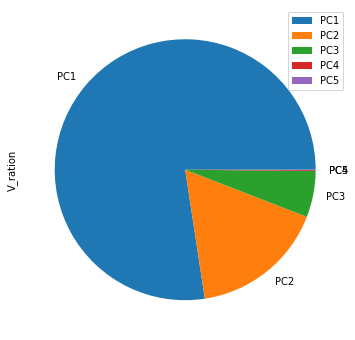

In [20]:
df_v = pd.DataFrame(ratio, index=['PC1','PC2','PC3','PC4','PC5'], columns=['V_ration'])
df_v.plot.pie(y='V_ration')
df_v

In [21]:
new_korea_df.head(5)

,Id,date,test,negative,confirmed,released,deceased,confirmed/test
0,13021,2020-01-22,4,3,1,0,0,25.000000
1,13022,2020-01-23,22,21,1,0,0,4.545455
2,13023,2020-01-24,27,25,2,0,0,7.407407
3,13024,2020-01-25,27,25,2,0,0,7.407407
4,13025,2020-01-26,51,47,3,0,0,5.882353


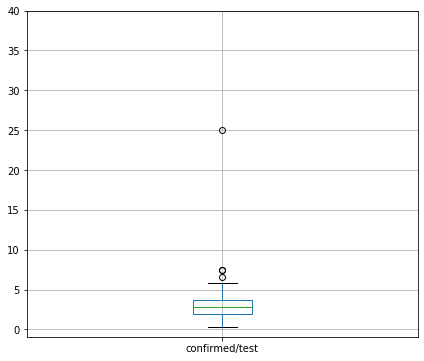

In [30]:
plt.figure(figsize=(7,6)) #크기지정
boxplot = new_korea_df.boxplot(column=['confirmed/test'])
plt.yticks(np.arange(0,41, step=5))
plt.show()

In [0]:
# 이상치 제거 함수
def removeOutliers(x, column):
    # Q1, Q3구하기
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    
    # 1.5 * IQR(Q3 - Q1)
    iqt = 1.5 * (q3 - q1)
    
    # 원래 데이터 복제
    y = x
    
    # 이상치를 NA로 변환
    y["confirmed/test"][(new_korea_df["confirmed/test"] > (q3 + iqt)) | (new_korea_df["confirmed/test"] < (q1 - iqt))] = None
    y["confirmed/test"]
    
    # y 반환
    return(y)

In [36]:
removeOutliers(new_korea_df,'confirmed/test')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Id,date,test,negative,confirmed,released,deceased,confirmed/test
0,13021,2020-01-22,4,3,1,0,0,NaN
1,13022,2020-01-23,22,21,1,0,0,4.545455
2,13023,2020-01-24,27,25,2,0,0,NaN
3,13024,2020-01-25,27,25,2,0,0,NaN
4,13025,2020-01-26,51,47,3,0,0,5.882353
5,13026,2020-01-27,61,56,4,0,0,NaN
6,13027,2020-01-28,116,97,4,0,0,3.448276
7,13028,2020-01-29,187,155,4,0,0,2.139037
8,13029,2020-01-30,246,199,6,0,0,2.439024
9,13030,2020-01-31,312,245,11,0,0,3.525641


In [44]:
new_korea_dropna_df = new_korea_df.dropna()
new_korea_dropna_df

,Id,date,test,negative,confirmed,released,deceased,confirmed/test
1,13022,2020-01-23,22,21,1,0,0,4.545455
4,13025,2020-01-26,51,47,3,0,0,5.882353
6,13027,2020-01-28,116,97,4,0,0,3.448276
7,13028,2020-01-29,187,155,4,0,0,2.139037
8,13029,2020-01-30,246,199,6,0,0,2.439024
9,13030,2020-01-31,312,245,11,0,0,3.525641
10,13031,2020-02-01,371,289,12,0,0,3.234501
11,13032,2020-02-02,429,327,15,0,0,3.496503
12,13033,2020-02-03,490,414,15,0,0,3.061224
13,13034,2020-02-04,607,462,16,0,0,2.635914


In [45]:
new_korea_dropna_df.corr()

,Id,test,negative,confirmed,released,deceased,confirmed/test
Id,1.000000,0.906294,0.881730,0.899703,0.640968,0.877213,0.218203
test,0.906294,1.000000,0.995482,0.986690,0.792581,0.994638,0.423210
negative,0.881730,0.995482,1.000000,0.974470,0.822694,0.998546,0.388813
confirmed,0.899703,0.986690,0.974470,1.000000,0.695639,0.971267,0.488020
released,0.640968,0.792581,0.822694,0.695639,1.000000,0.833211,0.148051
deceased,0.877213,0.994638,0.998546,0.971267,0.833211,1.000000,0.402283
confirmed/test,0.218203,0.423210,0.388813,0.488020,0.148051,0.402283,1.000000


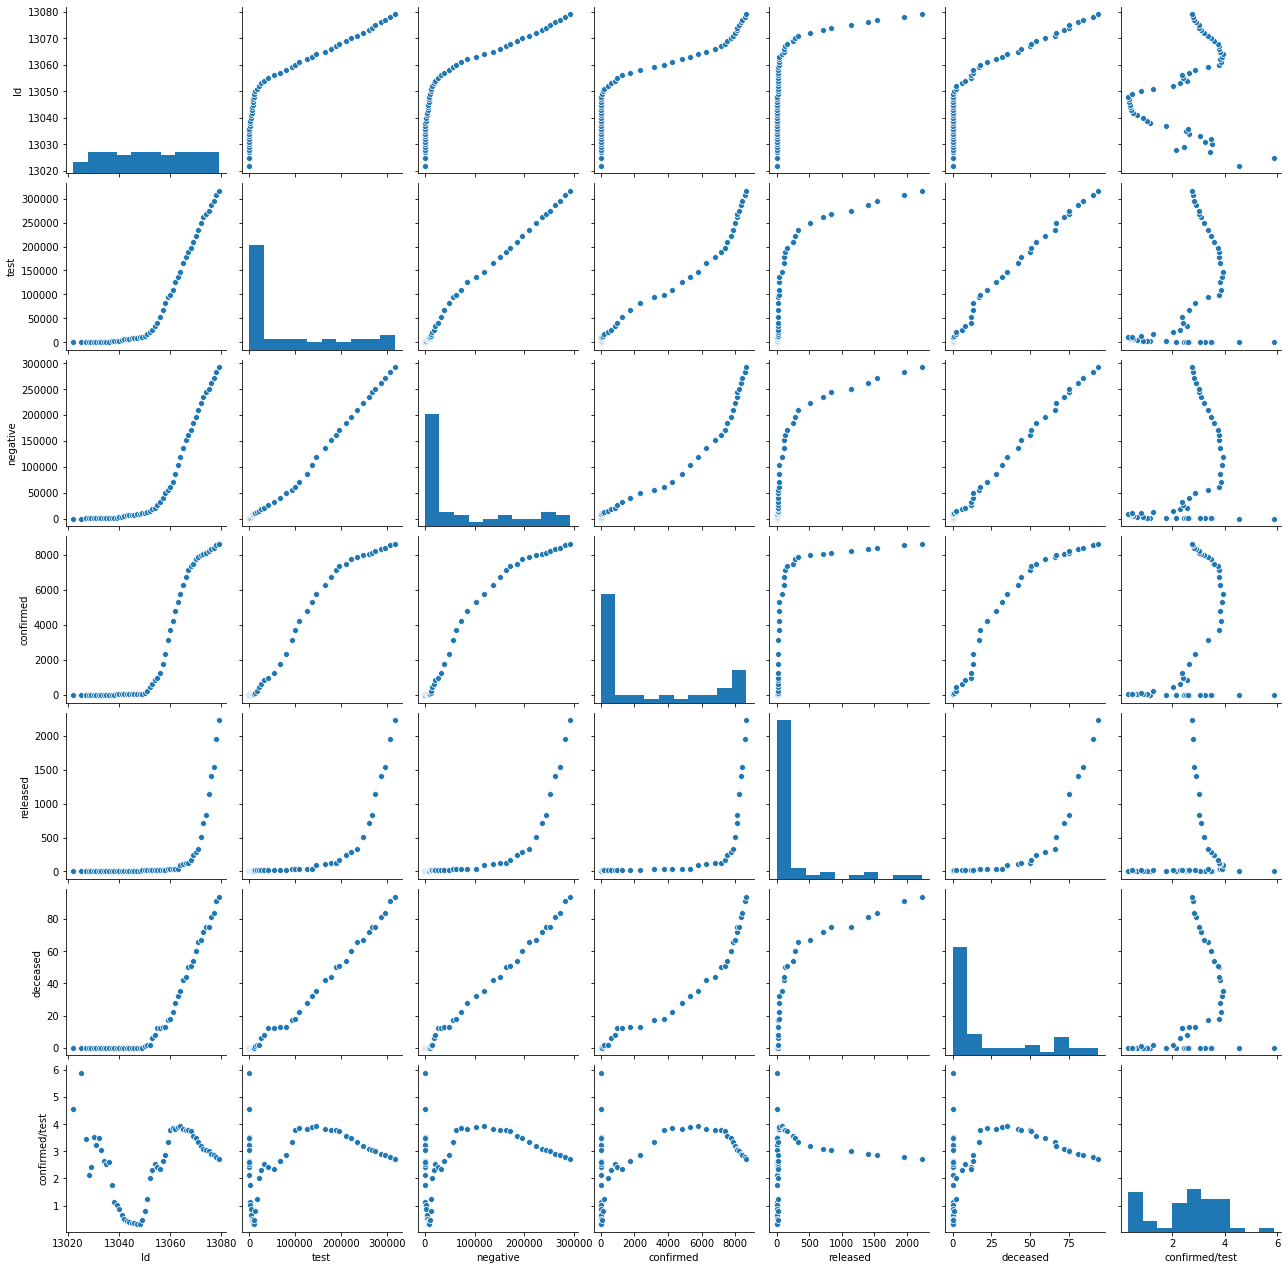

In [58]:
# scatterplot matrix with histogram only for continuous variables

sns.pairplot(new_korea_dropna_df, diag_kind='hist')

plt.show()

이 아래쪽으로 시계열분석 ARIMA모형을 도입해보려 했지만, 데이터 수가 부족하여 중간에 그만 두었음

In [0]:
new_korea_df['date'] = pd.to_datetime(new_korea_df['date'], format='%Y-%m-%d')
indexed_df = new_korea_df.set_index('date')

In [0]:
ts_test = indexed_df['test']
ts_negative = indexed_df['negative']
ts_confirmed = indexed_df['confirmed']
ts_released = indexed_df['released']
ts_deceased = indexed_df['deceased']
ts_confirmed_test = indexed_df['confirmed/test']

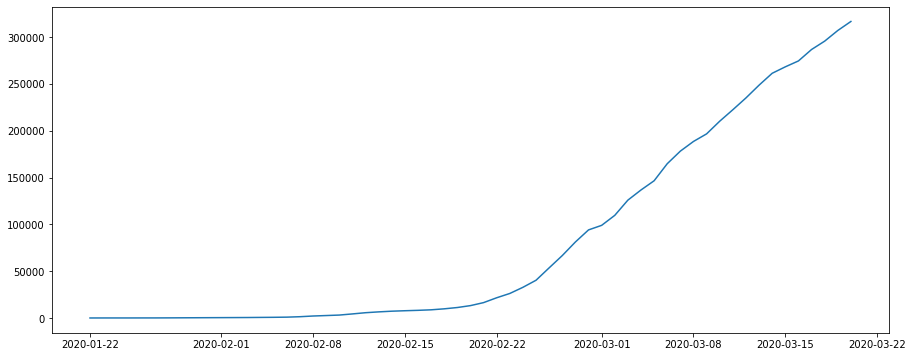

In [0]:
#검사자 수
plt.plot(ts_test.index.to_pydatetime(), ts_test.values)

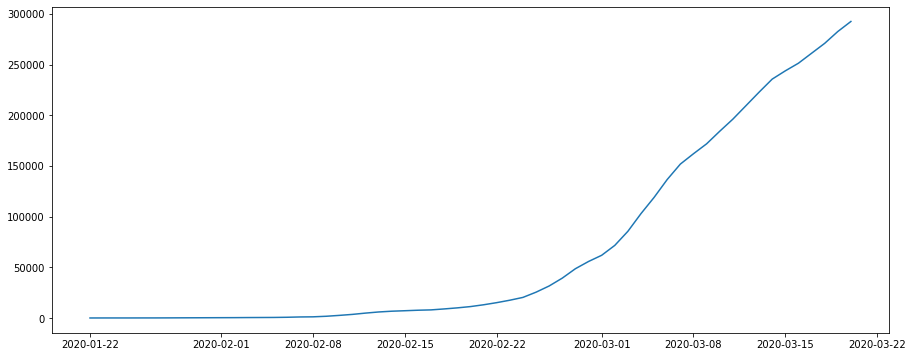

In [0]:
#음성
plt.plot(ts_negative.index.to_pydatetime(), ts_negative.values)

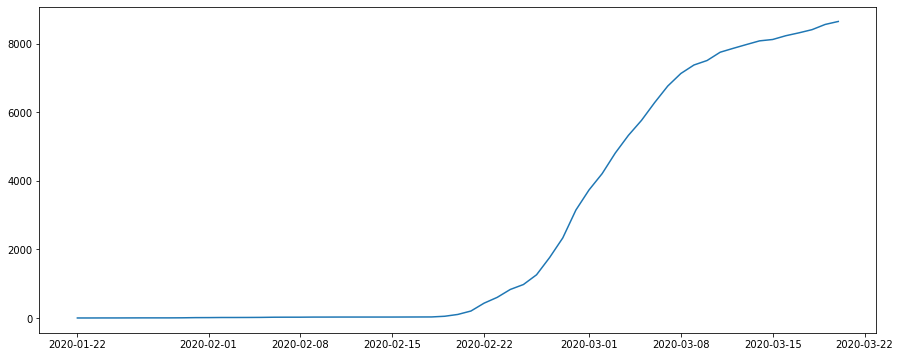

In [0]:
#확진자
plt.plot(ts_confirmed.index.to_pydatetime(), ts_confirmed.values)

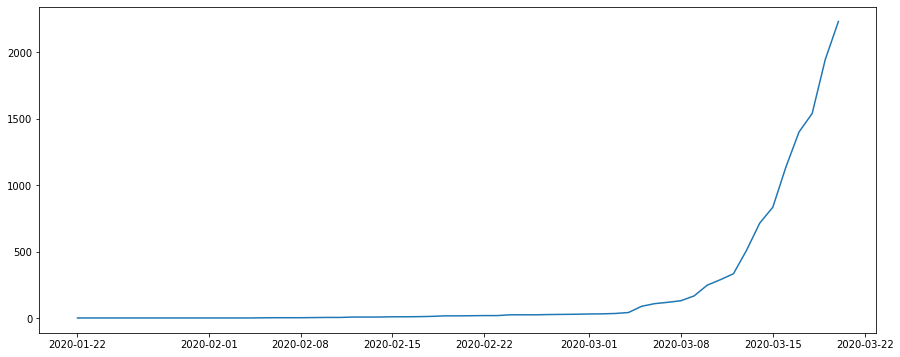

In [0]:
#격리해제
plt.plot(ts_released.index.to_pydatetime(), ts_released.values)

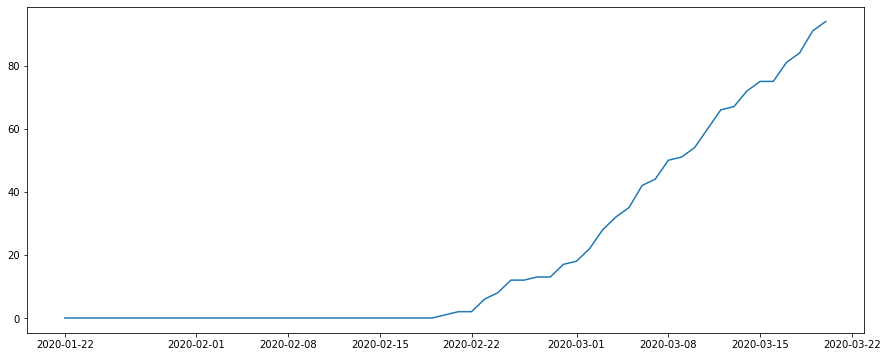

In [0]:
#사망자
plt.plot(ts_deceased.index.to_pydatetime(), ts_deceased.values)

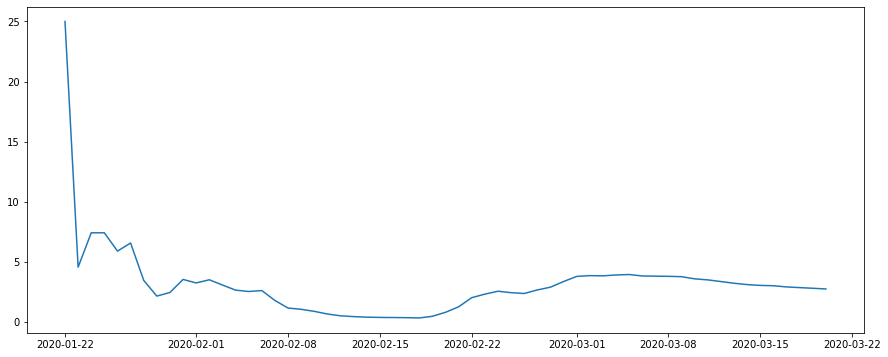

In [0]:
#확진자/검사자
plt.plot(ts_confirmed_test.index.to_pydatetime(), ts_confirmed_test.values)

In [0]:
ts_confirmed_week = ts_confirmed.resample('W').mean()

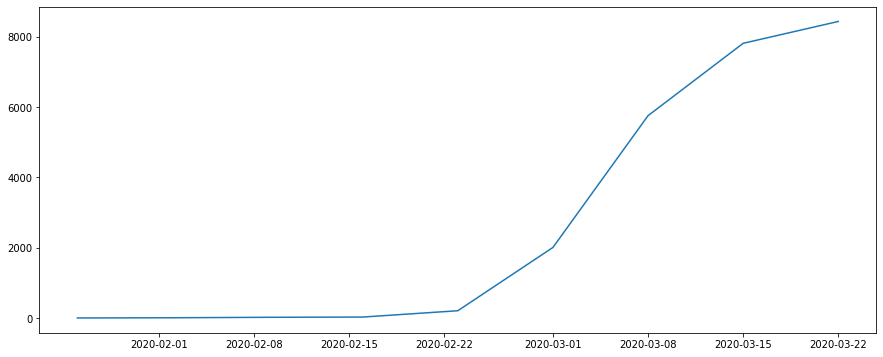

In [0]:
plt.plot(ts_confirmed_week.index.to_pydatetime(), ts_confirmed_week.values)

In [0]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

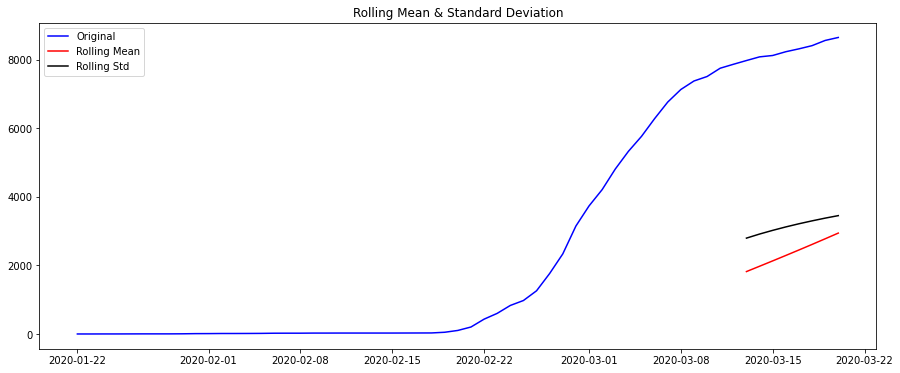

Results of Dickey-Fuller Test:
Test Statistic                 -1.101136
p-value                         0.714619
#Lags Used                      1.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [0]:
check_stationarity(ts_confirmed)